In [ ]:
!pip install hazm

# **Authentication**

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# **Load Train and Test Data**

In [ ]:
from google.colab import drive
import warnings
drive.mount('/gdrive',force_remount=True)
%cd /gdrive/MyDrive/Spam-filtering/emails

Mounted at /gdrive
/gdrive/MyDrive/Spam-filtering/emails


Load train data into pandas dataframe:



In [ ]:
import pandas as pd
import glob

hamtraining = glob.glob("/gdrive/MyDrive/Spam-filtering/emails/hamtraining/*.txt")
spamtraining = glob.glob("/gdrive/MyDrive/Spam-filtering/emails/spamtraining/*.txt")
train_data=pd.DataFrame(columns=['email','spam'])
for data_file in hamtraining:
  with open(data_file, 'r',encoding='utf8') as f:
    train_data=train_data.append({'email':f.read(),'spam':0},ignore_index=True)
for data_file in spamtraining:
  with open(data_file, 'r',encoding='utf8') as f:
    train_data=train_data.append({'email':f.read(),'spam':1},ignore_index=True)

Load test data into pandas dataframe:


In [ ]:
hamtesting=glob.glob("/gdrive/MyDrive/Spam-filtering/emails/hamtesting/*.txt")
spamtesting=glob.glob("/gdrive/MyDrive/Spam-filtering/emails/spamtesting/*.txt")
test_data=pd.DataFrame(columns=['email','spam'])
for data_file in hamtesting:
  with open(data_file, 'r',encoding='utf8') as f:
    test_data=test_data.append({'email':f.read(),'spam':0},ignore_index=True)
for data_file in spamtesting:
  with open(data_file, 'r',encoding='utf8') as f:
    test_data=test_data.append({'email':f.read(),'spam':1},ignore_index=True)

In [ ]:
test_data.shape

(400, 2)

Shuffle train dataframe 

In [ ]:
train_data = train_data.sample(frac = 1) 
train_data.head()

,email,spam
500,﻿ خود را با مد فصل جديد هماهنگ كنيد.\n\n﻿\n...,1
495,﻿ این مجموعه مخصوص افراد مشکل پسند است\n\nا...,1
248,﻿با سلام به شما دوست عزیز\nنمونه سوالات ازمون ...,0
276,﻿>> سلام عزیز\n>> سعی کردم تا جایی که در توانم...,0
41,﻿خانم صالح. من در دوره ی متوسطه و دوره ی لیسان...,0


# **PreProcessing**

In [ ]:
class const:

    farsi = ('ب', 'س', 'ش', 'ل', 'ت', 'ن', 'م', 'گ', 'ظ', 'ط', 'ز',
             'ر', 'ژ', 'ذ', 'د', 'پ', 'چ', 'ج', 'ح', 'ع', 'خ', 'غ', 'ف', 'ق', 'ث', 'ص', 'ض', ' ')

    alef = ('ا', 'آ', 'ء', 'أ', 'إ')
    vav = ('و', 'ؤ')
    heh = ('ه', 'ة', 'ە')
    yah = ('ی', 'ي', 'ئ', 'ى')
    kaf = ('ک', 'ك')


def finder(char):
    if char in const.alef:
        return const.alef[0]
    if char in const.farsi:
        return char
    elif char in const.vav:
        return const.vav[0]
    elif char in const.heh:
        return const.heh[0]
    elif char in const.yah:
        return const.yah[0]
    elif char in const.kaf:
        return const.kaf[0]
    return ''

def remove_non_farsi(text):
  text=text.replace("\n", " ")
  map_test = map(finder, text)
  result = ''.join(map_test)
  return result

normalize half spaces and some other stuff using hazm normalizer



In [ ]:
from hazm import Normalizer
normalizer = Normalizer()
train_data['email']=train_data['email'].apply(normalizer.normalize)
test_data['email']=test_data['email'].apply(normalizer.normalize)

remove english and special characters

In [ ]:
train_data['email']=train_data['email'].apply(remove_non_farsi)
test_data['email']=test_data['email'].apply(remove_non_farsi)

In [ ]:
train_data.head()

,email,spam
500,خود را با مد فصل جدید هماهنگ کنید انگشت...,1
495,این مجموعه مخصوص افراد مشکل پسند است این محص...,1
248,با سلام به شما دوست عزیز نمونه سوالات ازمون دک...,0
276,سلام عزیز سعی کردم تا جایی که در توانم بود م...,0
41,خانم صالح من در دورهی متوسطه و دورهی لیسانس در...,0


word tokenization, stop word removal and stemming 

In [ ]:
from hazm import Stemmer, word_tokenize, utils
stemmer=Stemmer()
def preprocess(text):
  words=[stemmer.stem(w) for w in word_tokenize(text) if w not in utils.stopwords_list()]
  return ' '.join(words)

In [ ]:
train_data['email']=train_data['email'].apply(preprocess)
test_data['email']=test_data['email'].apply(preprocess)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_data['email'],train_data['spam'],test_size=0.2,random_state=42)
x_test=test_data['email']
y_test=test_data['spam']

In [ ]:
x_train.shape

(480,)

# **Feature Selection with chi2**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,1),min_df=5)
vectorizer.fit(x_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=5000, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
x_train_vec = vectorizer.transform(x_train).toarray()
x_val_vec = vectorizer.transform(x_val).toarray()
x_test_vec = vectorizer.transform(test_data['email']).toarray()

In [ ]:
x_train_vec.shape

(480, 2079)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
transformer = SelectKBest(chi2, k=200).fit(x_train_vec, y_train.to_list())

In [ ]:
x_train_chi2 = transformer.transform(x_train_vec)
x_val_chi2=transformer.transform(x_val_vec)
x_test_chi2=transformer.transform(x_test_vec)

In [ ]:
type(x_test_chi2)

numpy.ndarray

Text(0.5, 0, '$\\chi^2$')

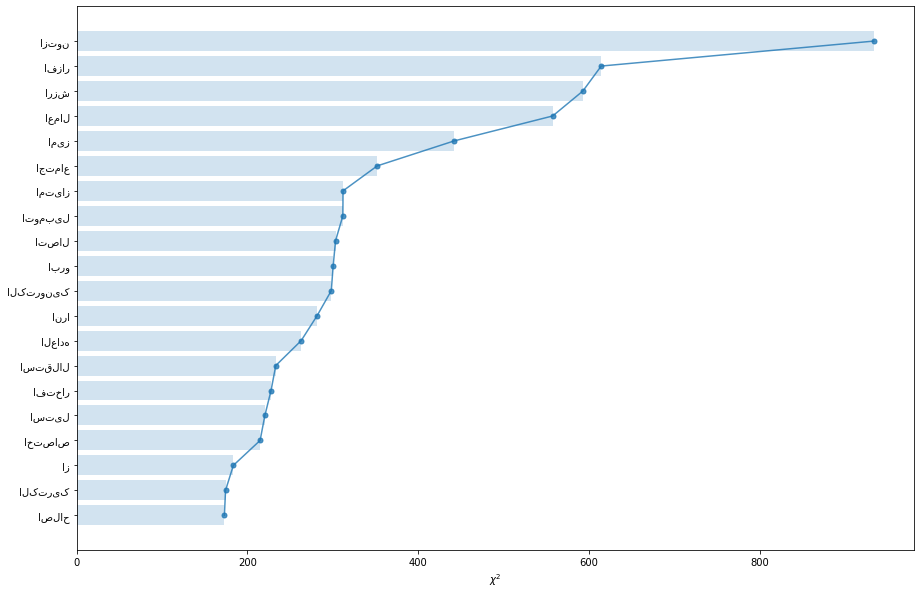

In [ ]:
import matplotlib.pyplot as plt

chi2score = chi2(x_train_chi2, y_train.to_list())[0]

plt.figure(figsize=(15,10))
wscores = zip(vectorizer.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = zip(*wchi2[-20:])
lst_topchi2=list(topchi2)
x = range(len(lst_topchi2[1]))
labels = lst_topchi2[0]
plt.barh(x,lst_topchi2[1], align='center', alpha=0.2)
plt.plot(lst_topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

# **KNN with cosine similarity**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
import numpy as np
# Counter to help with label voting
from collections import Counter

def knn_cosine_predict(x_train, x_test, y_train, y_test, k):

    # Make predictions on the test data
    # Need output of 1 prediction per test data point
    y_hat = []

    for test_point in x_test:
        distances = []

        for train_point in x_train:
            distance = 1-cosine_similarity(test_point.reshape(1,-1), train_point.reshape(1,-1))[0][0]
            distances.append(distance)
        # Store distances in a dataframe
        df_dists = pd.DataFrame(data=distances, columns=['dist'], 
                                index=y_train.index)
        
        # Sort distances, and only consider the k closest points
        df_nn = df_dists.sort_values(by=['dist'], axis=0)[:k]

        # Create counter object to track the labels of k closest neighbors
        counter = Counter(y_train[df_nn.index])
        # Get most common label of all the nearest neighbors
        prediction = counter.most_common()[0][0]
        
        # Append prediction to output list
        y_hat.append(prediction)
        
    return y_hat


Get accuracy score for validation set prediction with k=5

In [ ]:
# Get  accuracy score

from sklearn.metrics import accuracy_score
y_val_pred_knn_cosine=knn_cosine_predict(x_train_chi2, x_val_chi2, y_train, y_val, k=5)
print(accuracy_score(y_val.to_list(), y_val_pred_knn_cosine))

0.8916666666666667


### **Hyperparameter tuning**

In [ ]:
knn_cosine_accuracy=[]
k_values=[]
for k in range(1,10):
  y_pred_knn_cosine=knn_cosine_predict(x_train_chi2, x_val_chi2, y_train, y_val, k=k)
  knn_cosine_accuracy.append(accuracy_score(y_val.to_list(), y_pred_knn_cosine))
  k_values.append(k)

[0.95, 0.95, 0.925, 0.95, 0.8916666666666667, 0.9166666666666666, 0.8916666666666667, 0.9333333333333333, 0.8916666666666667]
1


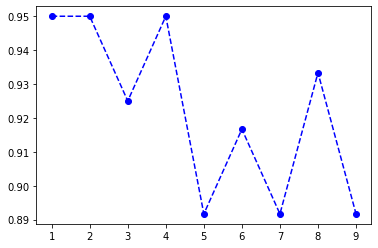

In [ ]:
plt.plot(k_values,knn_cosine_accuracy,'--bo')
print(knn_cosine_accuracy)
best_k=knn_cosine_accuracy.index(max(knn_cosine_accuracy))+1
print(best_k)

### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

knn_cosine_pred=knn_cosine_predict(x_train_chi2, x_test_chi2, y_train, y_test, k=best_k)

print(classification_report(y_test.to_list(),knn_cosine_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       200
           1       0.87      0.86      0.87       200

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



In [ ]:
knn_cosine_score=accuracy_score(y_test.to_list(),knn_cosine_pred)
print(knn_cosine_score)

0.87


### **Confusion matrix**

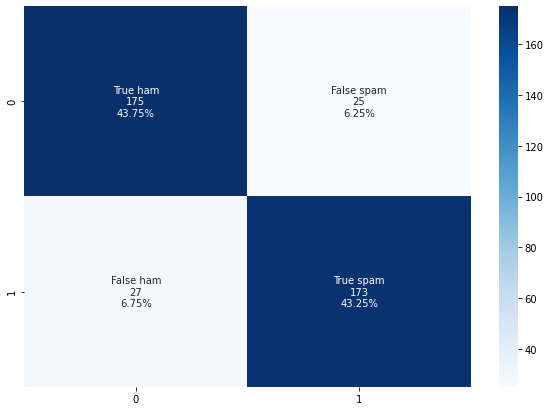

In [ ]:
import seaborn as sn

cm = confusion_matrix(y_test.to_list(), knn_cosine_pred)

group_names = ['True ham','False spam','False ham','True spam']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=labels, fmt='', cmap='Blues')



# sn.heatmap(cm/np.sum(cm), annot=True,fmt='.2%', cmap='Blues')

plt.show()

# **KNN with tf-idf**

In [ ]:
from collections import defaultdict
def compute_count(bag_of_words):
  words_count= defaultdict(lambda: 0) 
  for word in bag_of_words:
    words_count[word]+=1
  return words_count

In [ ]:
import math
def compute_tf(word,word_dict):
  # word_dict : key-> word val-> times of appearance in that email
    count=word_dict[word]
    tf=math.log(count+1)
    return tf

In [ ]:
def compute_idf(word,documents):
    N = len(documents)
    df=0
    for document in documents:
      if word in document.split(' '):
        df+= 1
    
    idf=math.log(N/(df+1))
    return idf

In [ ]:
def compute_tfidf(tfs, idfs):
    tfidf = []
    for tf , idf in zip(tfs,idfs):
      tfidf.append(tf*idf)

    return sum(tfidf)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
import numpy as np

# Counter to help with label voting
from collections import Counter

def knn_tfidf_predict(x_train, x_test, y_train, y_test, k):

    # Make predictions on the test data
    # Need output of 1 prediction per test data point
    y_hat = []

    for test_d in x_test:

        similarities = []
        bow_test = list(np.unique(np.array(test_d.split(' '))))

        idfs = [compute_idf(word, x_train) for word in bow_test]

        for train_d in x_train:
            bow_train=train_d.split(' ')
            word_dict=computeCount(bow_train)
            
            tfs=[compute_tf(word,word_dict) for word in bow_test]
            tf_idf=compute_tfidf(tfs,idfs)
            similarities.append(tf_idf)
        # Store distances in a dataframe
        df_dists = pd.DataFrame(data=similarities, columns=['sim'], 
                                index=y_train.index)
        
        # Sort distances, and only consider the k closest points
        df_nn = df_dists.sort_values(by=['sim'], axis=0,ascending=False)[:k]
        # Create counter object to track the labels of k closest neighbors
        counter = Counter(y_train[df_nn.index])
        # Get most common label of all the nearest neighbors
        prediction = counter.most_common()[0][0]
        
        # Append prediction to output list
        y_hat.append(prediction)
        
    return y_hat


get accuracy score for validation set prediction with k=5

In [ ]:
#  Get test accuracy score

from sklearn.metrics import accuracy_score
y_val_pred_knn_tfidf=knn_tfidf_predict(x_train, x_val, y_train, y_val, k=5)
print(accuracy_score(y_val.to_list(), y_val_pred_knn_tfidf))

0.8833333333333333


### **Hyperparameter tuning**

In [ ]:
knn_tfidf_accuracy=[]
k_tfidf_values=[]
for k in range(1,5):
  y_pred_knn_tfidf=knn_tfidf_predict(x_train, x_val, y_train, y_val, k=k)
  knn_tfidf_accuracy.append(accuracy_score(y_val.to_list(), y_pred_knn_tfidf))
  k_tfidf_values.append(k)

[0.95, 0.95, 0.925, 0.95, 0.8916666666666667, 0.9166666666666666, 0.8916666666666667, 0.9333333333333333, 0.8916666666666667]
1


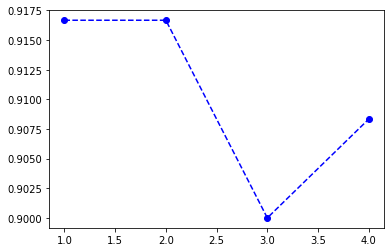

In [ ]:
plt.plot(k_tfidf_values,knn_tfidf_accuracy,'--bo')
print(knn_cosine_accuracy)
best_k_tfidf=knn_tfidf_accuracy.index(max(knn_tfidf_accuracy))+1
print(best_k_tfidf)

### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

knn_tfidf_pred=knn_tfidf_predict(x_train, x_test, y_train, y_test, k=best_k_tfidf)

print(classification_report(y_test.to_list(),knn_tfidf_pred))

              precision    recall  f1-score   support

           0       0.95      0.73      0.82       200
           1       0.78      0.96      0.86       200

    accuracy                           0.84       400
   macro avg       0.86      0.84      0.84       400
weighted avg       0.86      0.84      0.84       400



In [ ]:
knn_tfidf_score=accuracy_score(y_test.to_list(),knn_tfidf_pred)
print(knn_tfidf_score)

0.845


### **Confusion matrix**

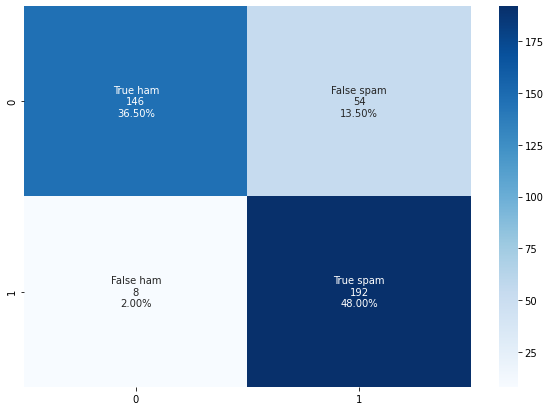

In [ ]:
import seaborn as sn

cm = confusion_matrix(y_test.to_list(), knn_tfidf_pred)

group_names = ['True ham','False spam','False ham','True spam']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=labels, fmt='', cmap='Blues')

plt.show()

# **Naive bayes**

In [ ]:
from collections import defaultdict
import re

class NaiveBayes:
    
    def __init__(self,unique_classes):
        
        self.classes=unique_classes # Constructor is sinply passed with unique number of classes of the training set
        
    def addToBow(self,example,dict_index):
  
        """
              input:
                1. example 
                2. dict_index - implies to which BoW category this example belongs to
              ouput: Nothing 
        """

        if isinstance(example,np.ndarray):
          example=example[0]
     
        for token_word in example.split(): #for every word in preprocessed example
          
            self.bow_dicts[dict_index][token_word]+=1 #increment in its count
            
    def train(self,dataset,labels):
        
        '''
            input:
              1. dataset - shape = (m X d)
              2. labels - shape = (m,)
            ouput: Nothing    
        '''
    
        self.examples=dataset
        self.labels=labels
        self.bow_dicts=np.array([defaultdict(lambda:0) for index in range(self.classes.shape[0])])

        if not isinstance(self.examples,np.ndarray): self.examples=np.array(self.examples)
        if not isinstance(self.labels,np.ndarray): self.labels=np.array(self.labels)
            
        #constructing BoW for each category
        for cat_index,cat in enumerate(self.classes):
          
            all_cat_examples=self.examples[self.labels==cat] 

            examples_list=[cat_example for cat_example in all_cat_examples]
            
            examples_list=pd.DataFrame(data=examples_list)
            
            #now costruct BoW of this particular category
            np.apply_along_axis(self.addToBow,1,examples_list,cat_index)
                
      # -----------------------------------------------------------
      
        prob_classes=np.empty(self.classes.shape[0])
        all_words=[]
        cat_word_counts=np.empty(self.classes.shape[0])
        for cat_index,cat in enumerate(self.classes):
           
            #Calculating prior probability p(c) for each class
            prob_classes[cat_index]=np.sum(self.labels==cat)/float(self.labels.shape[0]) 
            
            #Calculating total counts of all the words of each class 
            count=list(self.bow_dicts[cat_index].values())
            cat_word_counts[cat_index]=np.sum(np.array(list(self.bow_dicts[cat_index].values())))+1 # |v| is remaining to be added
            
            #get all words of this category                                
            all_words+=self.bow_dicts[cat_index].keys()
                                                     
        #get vocabulary -V- of entire training set
        self.vocab=np.unique(np.array(all_words))
        self.vocab_length=self.vocab.shape[0]
                                  
        #computing denominator value                                      
        denoms=np.array([cat_word_counts[cat_index]+self.vocab_length+1 for cat_index,cat in enumerate(self.classes)])                                                                          
        
        self.cats_info=[(self.bow_dicts[cat_index],prob_classes[cat_index],denoms[cat_index]) for cat_index,cat in enumerate(self.classes)]                               
        self.cats_info=np.array(self.cats_info)                                                                            
                                              
    def getExampleProb(self,test_example):                                
        
        '''
            input: a single test example 

            ouput: probability of test example in ALL CLASSES
        '''                                      
                                              
        likelihood_prob=np.zeros(self.classes.shape[0]) #to store probability w.r.t each class
        
        #finding probability w.r.t each class of the given test example
        for cat_index,cat in enumerate(self.classes): 
                             
            for test_token in test_example.split(): #split the test example and get p of each test word
                                          
                #This loop computes : for each word w [ count(w|c)+1 ] / [ count(c) + |V| + 1 ]                                                      
                
                #get total count of this test token from it's respective training dict to get numerator value                           
                test_token_counts=self.cats_info[cat_index][0].get(test_token,0)+1
                
                #now get likelihood of this test_token word                              
                test_token_prob=test_token_counts/float(self.cats_info[cat_index][2])                              
                
                #remember why taking log? To prevent underflow!
                likelihood_prob[cat_index]+=np.log(test_token_prob)
                                              
        # we have likelihood estimate of the given example against every class but we need posterior probility
        post_prob=np.empty(self.classes.shape[0])
        for cat_index,cat in enumerate(self.classes):
            post_prob[cat_index]=likelihood_prob[cat_index]+np.log(self.cats_info[cat_index][1])                                  
      
        return post_prob
    
   
    def test(self,test_set):
      
        '''
            input: A complete test set of shape (m,)
            output: Predictions of test examples - A single prediction against every test example
        '''       
       
        predictions=[]
        for example in test_set:                               

            post_prob=self.getExampleProb(example) #get prob of this example for both classes
            
            #simply pick the max value and map against self.classes!
            predictions.append(self.classes[np.argmax(post_prob)])
                
        return np.array(predictions)

In [ ]:
nb=NaiveBayes(np.unique(y_train))
nb.train(x_train,y_train)

In [ ]:
nb_pred=nb.test(x_test)
nb_accuracy_score=accuracy_score(y_test.to_list(),nb_pred)

### **Classification Report**

In [ ]:
print(classification_report(y_test.to_list(),nb_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       200
           1       0.99      0.92      0.95       200

    accuracy                           0.95       400
   macro avg       0.96      0.96      0.95       400
weighted avg       0.96      0.95      0.95       400



### **Confusion matrix**

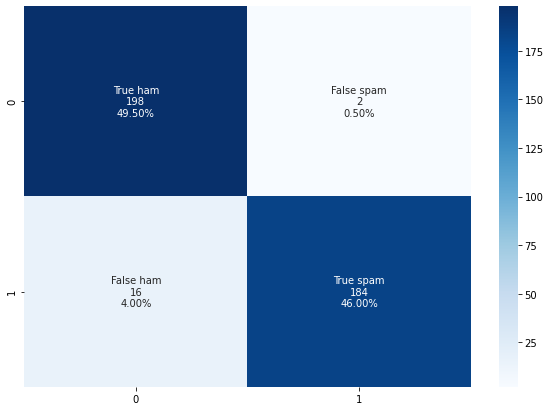

In [ ]:
import seaborn as sn

cfm = confusion_matrix(y_test.to_list(), nb_pred)

group_names = ['True ham','False spam','False ham','True spam']
group_counts = ['{0:0.0f}'.format(value) for value in cfm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cfm.flatten()/np.sum(cfm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (10,7))
sn.heatmap(cfm, annot=labels, fmt='', cmap='Blues')

plt.show()

# **Compare three algorithms' accuracy**

No handles with labels found to put in legend.


<Figure size 648x432 with 0 Axes>

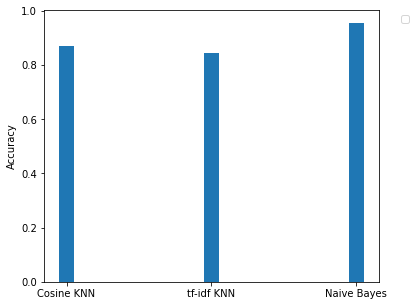

In [ ]:
plt.figure(figsize=(9, 6))
names=['Cosine KNN','tf-idf KNN','Naive Bayes']
scores=[knn_cosine_score,knn_tfidf_score,nb_accuracy_score]
plt.figure(figsize = (6, 5))
plt.bar(names,scores,width=0.1)
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);
plt.show()